# How can you determine home value?

> ## Goal: 

* Discover drivers of determining home values.
* Use drivers to develop a machine learning model to predict home values.
* This information could be used to determine how much a house could or should cost based on current market

>> # Executive Summary

In [68]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import QuantileTransformer
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LassoLars
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import TweedieRegressor
from math import sqrt
from scipy.stats import pearsonr, spearmanr


from env import get_connection
import wrangle_zillow
import prepare


# turn off pink boxes for demo
import warnings
warnings.filterwarnings("ignore")

> # Acquire the data

- I originally acquired the data from Codeup SQL server, I then saved it to a csv
- The dataset, before preparation has 63 columns and 52441 rows
- Each observation (row) represents details about each individual customer
- Each column represents variables associated with the observations of each customer

In [2]:
df = wrangle_zillow.wrangle_zillow()
df.head()

,bath,bed,sqft,fin_sqft,fips,full_bath,lotsize,zipcode,rooms,yearbuilt,taxvaluedollarcnt
0,3,4,3100.0,3100.0,6059,3.0,4506.0,96978.0,0.0,1998,1023282
1,1,2,1465.0,1465.0,6111,1.0,12647.0,97099.0,5.0,1967,464000
2,2,3,1243.0,1243.0,6059,2.0,8432.0,97078.0,6.0,1962,564778
3,3,4,2376.0,2376.0,6037,3.0,13038.0,96330.0,0.0,1970,145143
4,3,4,2962.0,2962.0,6037,3.0,63000.0,96293.0,0.0,1950,773303


> ### Internet Search
According to opendoor.com, these are 8 critical factors that influence a home’s value:
* Neighborhood comps
* Location
* Homesize & usable space
* Age & Condition
* ~Upgrades & Updates~
* ~Local Market~
* ~Economic indicators~
* ~Interest rates~

> # Prepare the data

- As part of my planning step, I had some ideas of the questions I wanted to answer, 
    This helped me decide what information was truly necessary for me to reach my conlcusions based on 
    what I was asking
- Knowing my preliminary questions, I decided to drop numerous columns I felt held 
    little to no value to help me reach my conclusions, such as extreme outliers, and minimal null values
- During some initial exploration of the data, I noticed the zipcode column had 11 rows with a 6 digit zipcode that       started with a number that didn't coincide with the other zipcodes, based on the fact that I still had 51696 rows     (or observations) left, I decided to remove those rows
- Once I felt I had all the data I needed and wanted to explore with, I created dummy variables to create binary 
    values for my data
- After preparation, my dataset was 14 columns and 51696 rows removing a minimal 1.4% of the data that wouldn't affect my findings

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 51696 entries, 0 to 52440
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   bath               51696 non-null  int64  
 1   bed                51696 non-null  int64  
 2   sqft               51696 non-null  float64
 3   fin_sqft           51696 non-null  float64
 4   fips               51696 non-null  int64  
 5   full_bath          51696 non-null  float64
 6   lotsize            51696 non-null  float64
 7   zipcode            51696 non-null  float64
 8   rooms              51696 non-null  float64
 9   yearbuilt          51696 non-null  int64  
 10  taxvaluedollarcnt  51696 non-null  int64  
dtypes: float64(6), int64(5)
memory usage: 4.7 MB


In [4]:
df = prepare.zillow_dummies(df)

df.head()

,bath,bed,sqft,fin_sqft,fips_6037,full_bath,lotsize,zipcode,rooms,yearbuilt,taxvalue,6037,6059,6111
0,3,4,3100.0,3100.0,0,3.0,4506.0,96978.0,0.0,1998,1023282.0,0,1,0
1,1,2,1465.0,1465.0,0,1.0,12647.0,97099.0,5.0,1967,464000.0,0,0,1
2,2,3,1243.0,1243.0,0,2.0,8432.0,97078.0,6.0,1962,564778.0,0,1,0
3,3,4,2376.0,2376.0,1,3.0,13038.0,96330.0,0.0,1970,145143.0,1,0,0
4,3,4,2962.0,2962.0,1,3.0,63000.0,96293.0,0.0,1950,773303.0,1,0,0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 51696 entries, 0 to 52440
Data columns (total 14 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   bath       51696 non-null  int64  
 1   bed        51696 non-null  int64  
 2   sqft       51696 non-null  float64
 3   fin_sqft   51696 non-null  float64
 4   fips_6037  51696 non-null  int64  
 5   full_bath  51696 non-null  float64
 6   lotsize    51696 non-null  float64
 7   zipcode    51696 non-null  float64
 8   rooms      51696 non-null  float64
 9   yearbuilt  51696 non-null  int64  
 10  taxvalue   51696 non-null  float64
 11  6037       51696 non-null  uint8  
 12  6059       51696 non-null  uint8  
 13  6111       51696 non-null  uint8  
dtypes: float64(7), int64(4), uint8(3)
memory usage: 4.9 MB


>> # Data Dictionary

|Feature|              Definition|
| :------|:------|
|bath|                      - tells how many half and full bathrooms in the house|
|bed|                       - tells how many bedrooms in the house|
|sqft|                      - tells the total square footage of the house itself|
|fin_sqft|                  - tells finished square footage of the house itself|
|fips|                      - tells the county code of the property| 
|full_bath|                 - tells the amount of full bathrooms only|
|lotsize|                   - tells the size of the entire property lot in square feet|
|zipcode|                       - tells what zip code the house is located |
|rooms|                     - tells how many total rooms there are in the house|
|yearbuilt|                 - tells you the year the house was built|
|taxvaluedollarcnt (TARGET)|         - tells you the value of the home|

> ## Splitting the data

In [6]:
train, val, test = prepare.train_val_test(df)
train.shape, val.shape, test.shape

((36187, 14), (9305, 14), (6204, 14))

> # Exploration

* Can the amount of bedrooms affect the ability to predict the value of a home?
* Can the amount of bathrooms affect the ability to predict the value of a home? 
* Can the size of the home affect the ability to predict the value of a home?

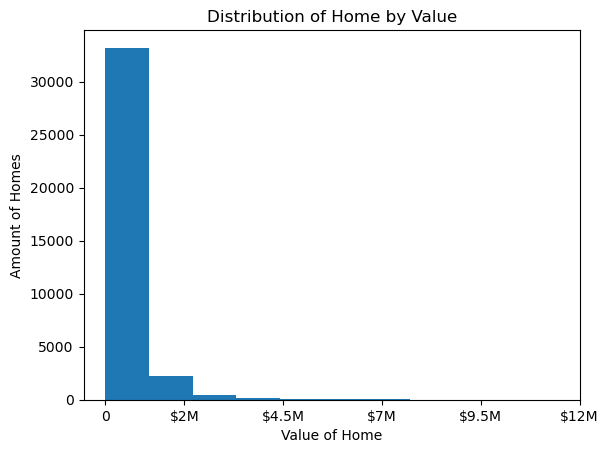

In [65]:
train.taxvalue.hist(grid = False)
plt.ylabel('Amount of Homes')
plt.xlabel('Value of Home')
plt.title('Distribution of Home by Value')
labels = ['0', '$2M', '$4.5M', '$7M', '$9.5M', '$12M']
plt.xticks(ticks = (0, 2000000, 4500000, 7000000, 9500000, 12000000), labels = labels)
plt.show()

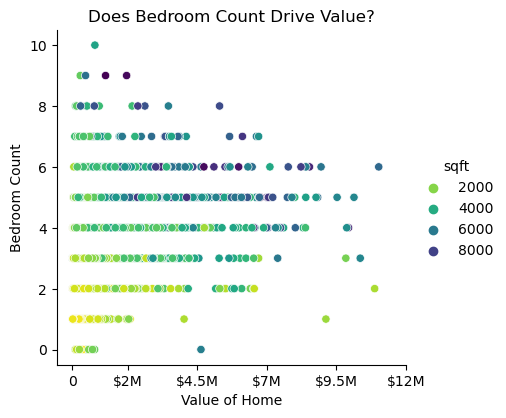

In [18]:
sns.pairplot(train, y_vars = ['bed'], x_vars = ['taxvalue'], 
             hue = 'sqft', corner = True, palette = 'viridis_r', height = 4)

plt.ylabel('Bedroom Count')
plt.xlabel('Value of Home')
plt.title('Does Bedroom Count Drive Value?')
labels = ['0', '$2M', '$4.5M', '$7M', '$9.5M', '$12M']
plt.xticks(ticks = (0, 2000000, 4500000, 7000000, 9500000, 12000000), labels = labels)
plt.show()

> Takeaway - Bedroom count doesn't necessarily drive the value of the home

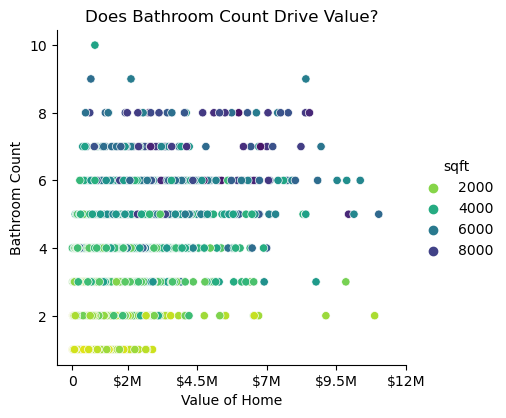

In [8]:
sns.pairplot(train, y_vars = ['bath'], x_vars = ['taxvalue'], 
             hue = 'sqft', corner = True, palette = 'viridis_r', height = 4)
plt.ylabel('Bathroom Count')
plt.xlabel('Value of Home')
plt.title('Does Bathroom Count Drive Value?')
labels = ['0', '$2M', '$4.5M', '$7M', '$9.5M', '$12M']
plt.xticks(ticks = (0, 2000000, 4500000, 7000000, 9500000, 12000000), labels = labels)
plt.show()

> Takeaway - Bathroom count does seem drive the value of the home moreso than bedroom count

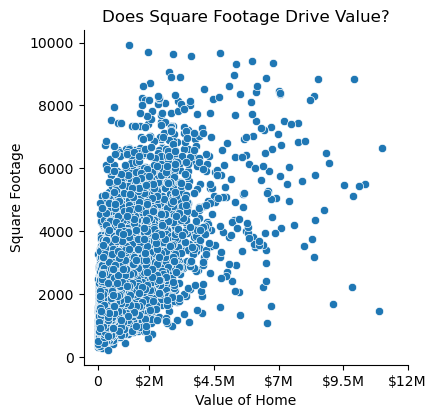

In [21]:
sns.pairplot(train, y_vars = ['sqft'], x_vars = ['taxvalue'], 
            corner = True, height = 4)
plt.ylabel('Square Footage')
plt.xlabel('Value of Home')
plt.title('Does Square Footage Drive Value?')
labels = ['0', '$2M', '$4.5M', '$7M', '$9.5M', '$12M']
plt.xticks(ticks = (0, 2000000, 4500000, 7000000, 9500000, 12000000), labels = labels)
plt.show()

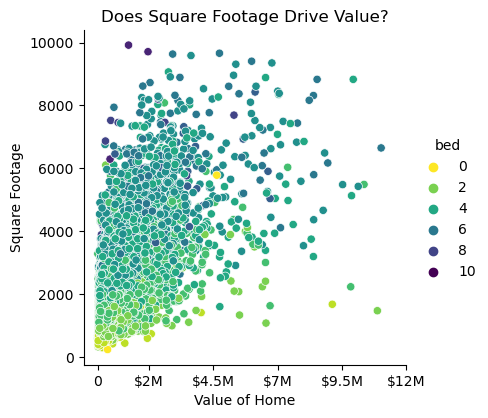

In [19]:
sns.pairplot(train, y_vars = ['sqft'], x_vars = ['taxvalue'], 
             hue = 'bed', corner = True, palette = 'viridis_r', height = 4)

plt.ylabel('Square Footage')
plt.xlabel('Value of Home')
plt.title('Does Square Footage Drive Value?')
labels = ['0', '$2M', '$4.5M', '$7M', '$9.5M', '$12M']
plt.xticks(ticks = (0, 2000000, 4500000, 7000000, 9500000, 12000000), labels = labels)
plt.show()

> Takeaway - The gradual change in color supports the fact that bedroom count can play a part in predicting value

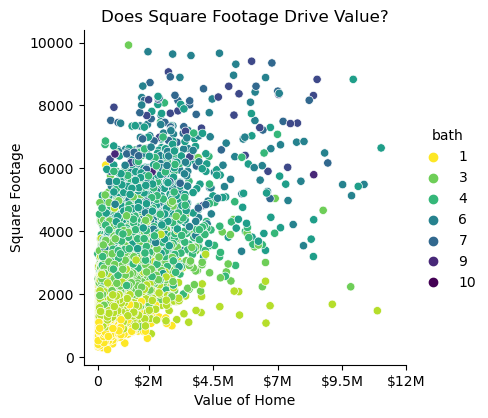

In [32]:
sns.pairplot(train, y_vars = ['sqft'], x_vars = ['taxvalue'], 
             hue = 'bath', corner = True, palette = 'viridis_r', height = 4)

plt.ylabel('Square Footage')
plt.xlabel('Value of Home')
plt.title('Does Square Footage Drive Value?')
labels = ['0', '$2M', '$4.5M', '$7M', '$9.5M', '$12M']
plt.xticks(ticks = (0, 2000000, 4500000, 7000000, 9500000, 12000000), labels = labels)
plt.show()

> Takeaway - There are distinct points in which the colors change signifying bathroom count does play a larger role in value than bedroom count

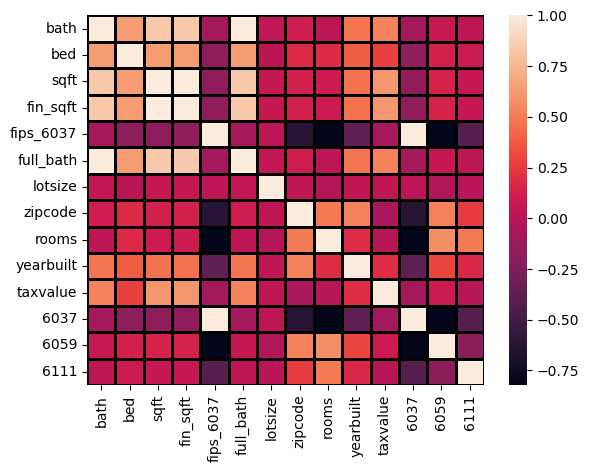

In [41]:
sns.heatmap(train.corr(), linecolor = 'black', linewidths = 1)
plt.show()

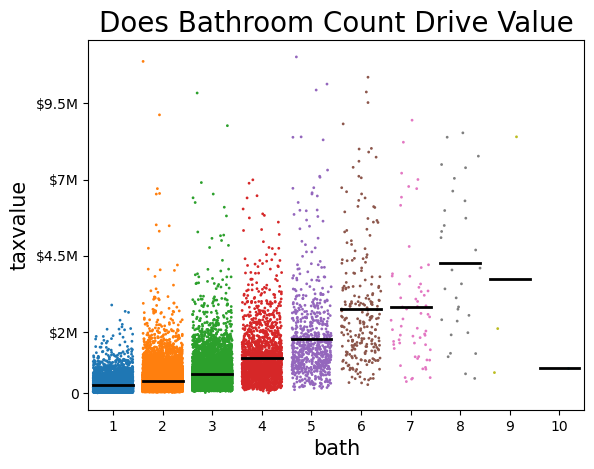

In [86]:
p = sns.stripplot(y = train.taxvalue, x = train.bath, data = train, size = 2, jitter = .4)
plt.ylabel('Value of Home', fontdict = { 'fontsize': 15})
plt.xlabel('Bathroom Count', fontdict = { 'fontsize': 15})
plt.title('Does Bathroom Count Drive Value', fontdict = { 'fontsize': 20})
labels = ['0', '$2M', '$4.5M', '$7M', '$9.5M', '$12M']
plt.yticks(ticks = (0, 2000000, 4500000, 7000000, 9500000, 12000000), labels = labels)
sns.boxplot(showmeans=True,
            meanline=True,
            meanprops={'color': 'k', 'ls': '-', 'lw': 2},
            medianprops={'visible': False},
            whiskerprops={'visible': False},
            zorder=10,
            x="bath",
            y="taxvalue",
            data=train,
            showfliers=False,
            showbox=False,
            showcaps=False,
            ax=p)
plt.show()


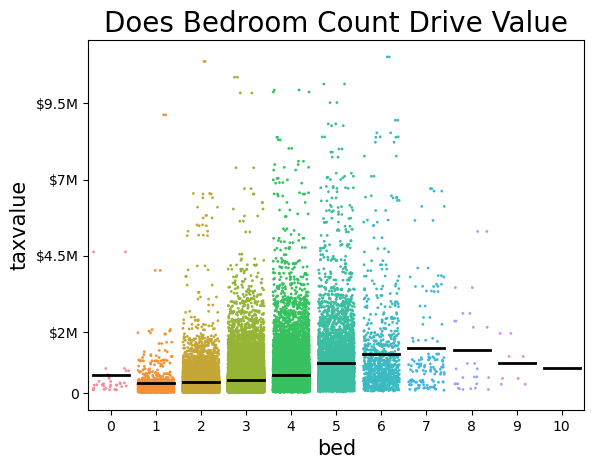

In [85]:
p = sns.stripplot(y = train.taxvalue, x = train.bed, data = train, size = 2, jitter = .4)
plt.ylabel('Value of Home', fontdict = { 'fontsize': 15})
plt.xlabel('Bedroom Count', fontdict = { 'fontsize': 15})
plt.title('Does Bedroom Count Drive Value', fontdict = { 'fontsize': 20})
labels = ['0', '$2M', '$4.5M', '$7M', '$9.5M', '$12M']
plt.yticks(ticks = (0, 2000000, 4500000, 7000000, 9500000, 12000000), labels = labels)

sns.boxplot(showmeans=True,
            meanline=True,
            meanprops={'color': 'k', 'ls': '-', 'lw': 2},
            medianprops={'visible': False},
            whiskerprops={'visible': False},
            zorder=10,
            x="bed",
            y="taxvalue",
            data=train,
            showfliers=False,
            showbox=False,
            showcaps=False,
            ax=p)
plt.show()

> Takeaway - It seems that there is no relationship to bedroom count and the value of the home

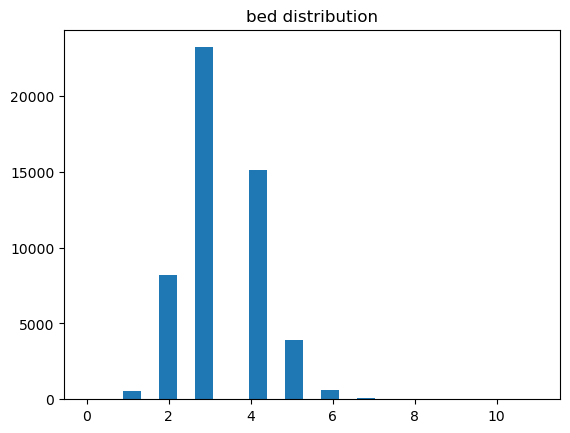

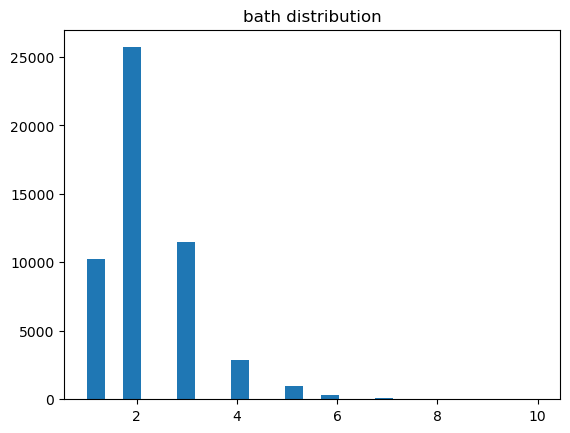

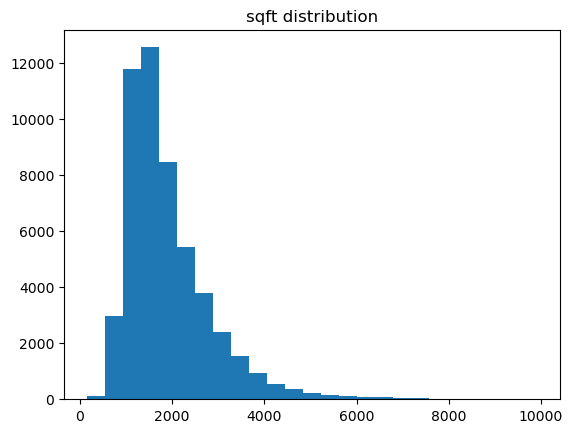

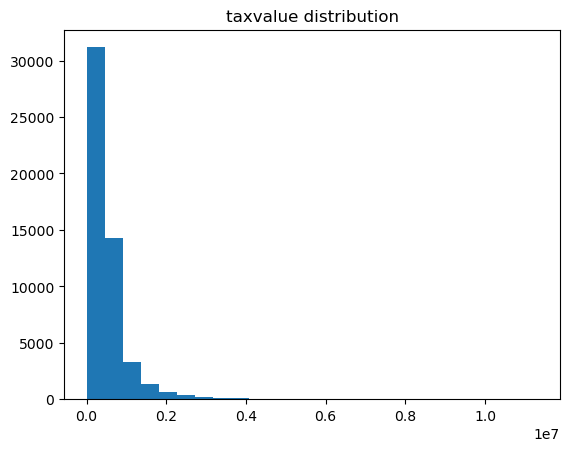

In [67]:
cont_var = ['bed', 'bath', 'sqft', 'taxvalue']

for col in cont_var:
    plt.hist(df[col], bins = 25)
    plt.title(f'{col} distribution')
    plt.show()

> Takeaway - 

In [69]:
r, p_value = pearsonr(train.bed, train.taxvalue)
print(f'Correlation Coefficient: {r}\nP-value: {p_value}')

Correlation Coefficient: 0.27721045023971624
P-value: 0.0


In [73]:
r, p_value = spearmanr(train.bath, train.taxvalue)
print(f'Correlation Coefficient: {r}\nP-value: {p_value}')

Correlation Coefficient: 0.45989464382757766
P-value: 0.0


In [74]:
r, p_value = spearmanr(train.sqft, train.taxvalue)
print(f'Correlation Coefficient: {r}\nP-value: {p_value}')

Correlation Coefficient: 0.5265245637021316
P-value: 0.0
